# Lab.6: Word Sense Disambiguation
## Author: Edison Bejarano - Roberto Ariosa

## Mandatory exercise

### Statement:

Read all pairs of sentences of the SMTeuroparl files of test set within the evaluation framework of the project.

- Apply Lesk’s algorithm to the words in the sentences.
- Compute their similarities by considering senses and Jaccard coefficient.
- Compare the results with those in session 2 (document) and 3 (morphology) in which words and lemmas were considered.
- Compare the results with gold standard by giving the pearson correlation between them.

# Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q pingouin
!cp /content/drive/MyDrive/Colab_Notebooks/2.IHLT/test-gold.tar .
!tar -xvf /content/test-gold.tar

test-gold/
test-gold/STS.input.MSRpar.txt
test-gold/STS.gs.MSRpar.txt
test-gold/STS.input.MSRvid.txt
test-gold/STS.gs.MSRvid.txt
test-gold/STS.input.SMTeuroparl.txt
test-gold/STS.gs.SMTeuroparl.txt
test-gold/STS.input.surprise.SMTnews.txt
test-gold/STS.gs.surprise.SMTnews.txt
test-gold/STS.input.surprise.OnWN.txt
test-gold/STS.gs.surprise.OnWN.txt
test-gold/STS.gs.ALL.txt
test-gold/00-readme.txt


In [ ]:
import os
import seaborn
import pandas as pd
import pingouin as pg
from scipy.stats import pearsonr

import nltk
from nltk.wsd import lesk
from nltk.metrics import jaccard_distance
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Helper functions

In [ ]:
def apply_jaccard_lesk(sentence1: str, sentence2: str):

  # Apply lesk to sentence 1
  synset1 = [ lesk(sentence1, word) for word in sentence1 ]
  synset1 = { word for word in synset1 if word is not None }

  # Apply lesk to sentence 1
  synset2 = [ lesk(sentence2, word) for word in sentence2 ]
  synset2 = { word for word in synset2 if word is not None }

  # Calculate distance
  distance = jaccard_distance(synset1, synset2)

  return distance

# ------------------------------ #
# Lemmatization text process
# ------------------------------ #

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"NN": "n",
                "NNS": "n",
                "NNP": "n",
                "NNPS": "n",
                "VB": "v",
                "VBD": "v",
                "VBG": "v",
                "VBN": "v",
                "VBP": "v",
                "VBZ": "v",
                "RB": "r",
                "RBR": "r",
                "RBS": "r",
                "JJ": "a",
                "JJR": "a",
                "JJS": "a",}
        
    return tag_dict.get(tag, wordnet.NOUN)


def lemmatize(column):
  return  [ list(lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in nltk.word_tokenize(sentence)) for sentence in column ]  

# ------------------------------ #
# Similarity Function
# ------------------------------ #
def jaccard_similarity(s1, s2):
  intersection = len(s1.intersection(s2))
  union = len(s1) + len(s2) - intersection
  return float(intersection) / float(union)



# Read test-gold data

In [ ]:
# ------------------------------ #
# Path test gold directory
# ------------------------------ #
path = '/content/test-gold'

In [ ]:
# ------------------------------ #
# Read dataset and return a list 
# with the files 
# ------------------------------ #
files = os.listdir(path)
files = pd.DataFrame(files)
files = path+"/"+files
files.head(9)

,0
0,/content/test-gold/STS.gs.SMTeuroparl.txt
1,/content/test-gold/STS.gs.MSRpar.txt
2,/content/test-gold/STS.gs.surprise.OnWN.txt
3,/content/test-gold/STS.input.SMTeuroparl.txt
4,/content/test-gold/STS.input.surprise.OnWN.txt
5,/content/test-gold/STS.gs.MSRvid.txt
6,/content/test-gold/STS.gs.surprise.SMTnews.txt
7,/content/test-gold/00-readme.txt
8,/content/test-gold/STS.input.surprise.SMTnews.txt


In [ ]:
# ------------------------------ #
# Path test gold directory
# ------------------------------ #
da = files[0][3]
df = pd.read_csv(da, sep='\t', header=None)
df.columns = ['Text1', 'Text2']
gold_file = files[0][0]
df["gs"] = pd.read_csv(gold_file, sep='\t', header=None)
df.head()

,Text1,Text2,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


# Compute similarity, lemmatization with similarity and LeskSimilarity

## Similarities

In [ ]:


#--------------------------------------------#
# Tokenize both columns that contain text
#--------------------------------------------#
df['text1_lemmatized'] = lemmatize(df['Text1'])
df['text2_lemmatized'] = lemmatize(df['Text2'])

#--------------------------------------------#
#Compute the jaccard similarity between 
#text1 and text2
#--------------------------------------------#
df['similarity'] = [jaccard_similarity(set(row['Text1']), set(row['Text2'])) for i,row in df.iterrows()]

#--------------------------------------------#
#Compute the jaccard similarity between 
#text1 and text2 after be lemmatized
#--------------------------------------------#
df['Lemma_similarity'] = [jaccard_similarity(set(row['text1_lemmatized']), set(row['text2_lemmatized'])) for i,row in df.iterrows()]

#--------------------------------------------#
#                 LeskSimilarity             #
#--------------------------------------------#

df['LeskSimilarity'] = df.apply(lambda row: apply_jaccard_lesk(set(row[0]), set(row[1])), axis=1)
# Replace  null data by cero to compute Pearson's correlation. #
df.head()


,Text1,Text2,gs,text1_lemmatized,text2_lemmatized,similarity,Lemma_similarity,LeskSimilarity
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50,"[the, leader, have, now, been, given, a, new, ...","[the, leader, benefit, aujourd, ', hui, of, a,...",0.678571,0.346154,0.304348
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00,"[amendment, no, 7, proposes, certain, change, ...","[amendment, no, 7, is, proposing, certain, cha...",1.000000,0.785714,0.000000
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25,"[let, me, remind, you, that, our, ally, includ...","[i, would, like, to, remind, you, that, among,...",0.666667,0.391304,0.238095
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50,"[the, vote, will, take, place, today, at, 5.30...","[the, vote, will, take, place, at, 5.30pm]",0.904762,0.545455,0.117647
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00,"[the, fisherman, are, inactive, ,, tired, and,...","[the, fisherman, are, inactive, ,, tired, and,...",1.000000,1.000000,0.000000


## Pearson's correlation

In [ ]:
#---------------------------------------------#
# (Similarity-gold score) Pearson Correlation #
#---------------------------------------------#
pearson_corr = (pearsonr(df['similarity'], df['gs']))[0]
print(f"Pearson's correlation Lab 2: ",pearson_corr)

#--------------------------------------------------#
# (LemmaSimilarity-gold score) Pearson Correlation #
#--------------------------------------------------#
pearson_corr_Lemma = (pearsonr(df['Lemma_similarity'], df['gs']))[0]
print(f"Pearson's correlation Lab 3: ",pearson_corr_Lemma)

#--------------------------------------------#
#         (Lesk-Gs) Pearson Correlation
#--------------------------------------------#
#df['gs'] = df['gs'].fillna(0)
pearson_corr_Lesk = (pearsonr(df['LeskSimilarity'], df['gs']))[0]
print(f"Pearson's correlation Lab 6: ",pearson_corr_Lesk)

Pearson's correlation Lab 2:  0.3971297709735514
Pearson's correlation Lab 3:  0.4707125711289244
Pearson's correlation Lab 6:  -0.3263167813871022


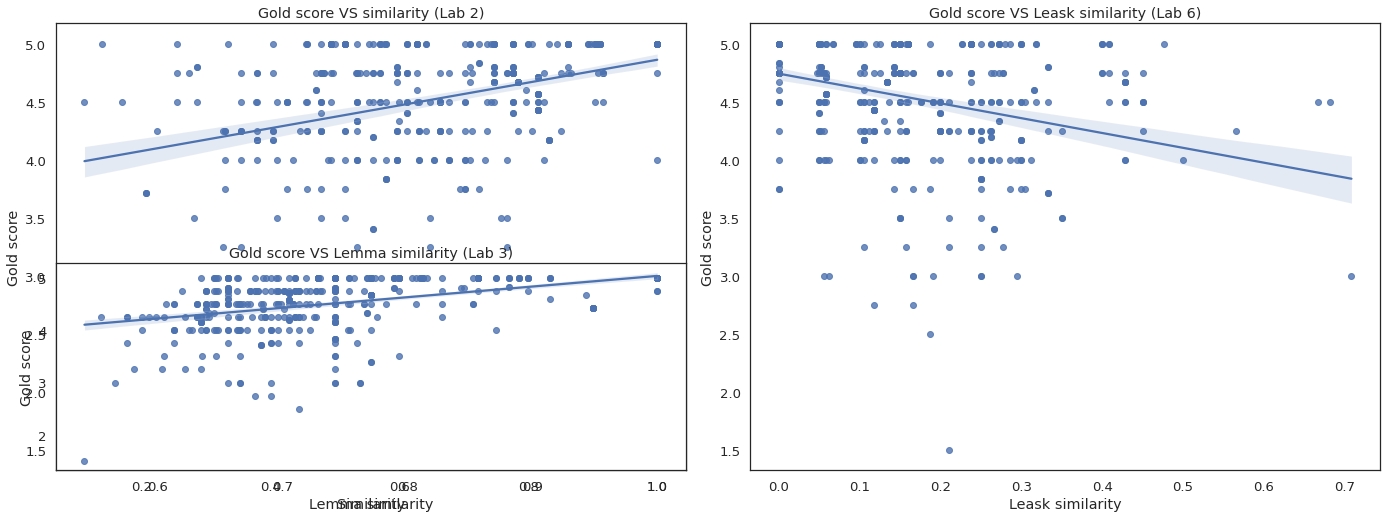

In [234]:
# plot scatterplots data and correlations
fig = plt.figure(figsize=(20,8))

fig.add_subplot(121)

seaborn.regplot(x="similarity", y="gs", fit_reg=True, data=df);
plt.xlabel('Similarity');
plt.ylabel('Gold score');
plt.title('Gold score VS similarity (Lab 2)');

fig.add_subplot(223)
seaborn.regplot(x="Lemma_similarity", y="gs", fit_reg=True, data=df);
plt.xlabel('Lemma similarity');
plt.ylabel('Gold score');
plt.title('Gold score VS Lemma similarity (Lab 3)');

fig.add_subplot(122)

seaborn.regplot(x="LeskSimilarity", y="gs", fit_reg=True, data=df);
plt.xlabel('Leask similarity');
plt.ylabel('Gold score');
plt.title('Gold score VS Leask similarity (Lab 6)');


fig.tight_layout()
plt.show()


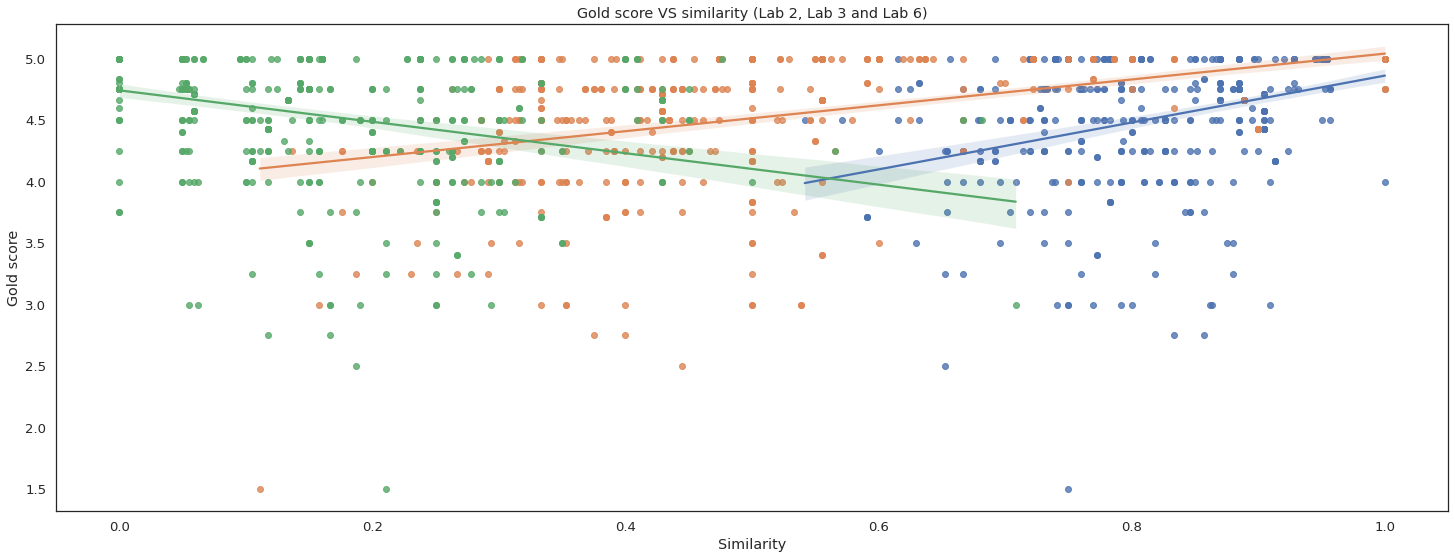

In [251]:
from matplotlib.pyplot import xlabel
# plot scatterplots data and correlations
fig = plt.figure(figsize=(40,8))

fig.add_subplot(121)
seaborn.regplot(x="similarity", y="gs", fit_reg=True, data=df);
seaborn.regplot(x="Lemma_similarity", y="gs", fit_reg=True, data=df);
seaborn.regplot(x="LeskSimilarity", y="gs", fit_reg=True, data=df);

plt.xlabel('Similarity');
plt.ylabel('Gold score');
plt.title('Gold score VS similarity (Lab 2, Lab 3 and Lab 6)');


fig.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 19.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


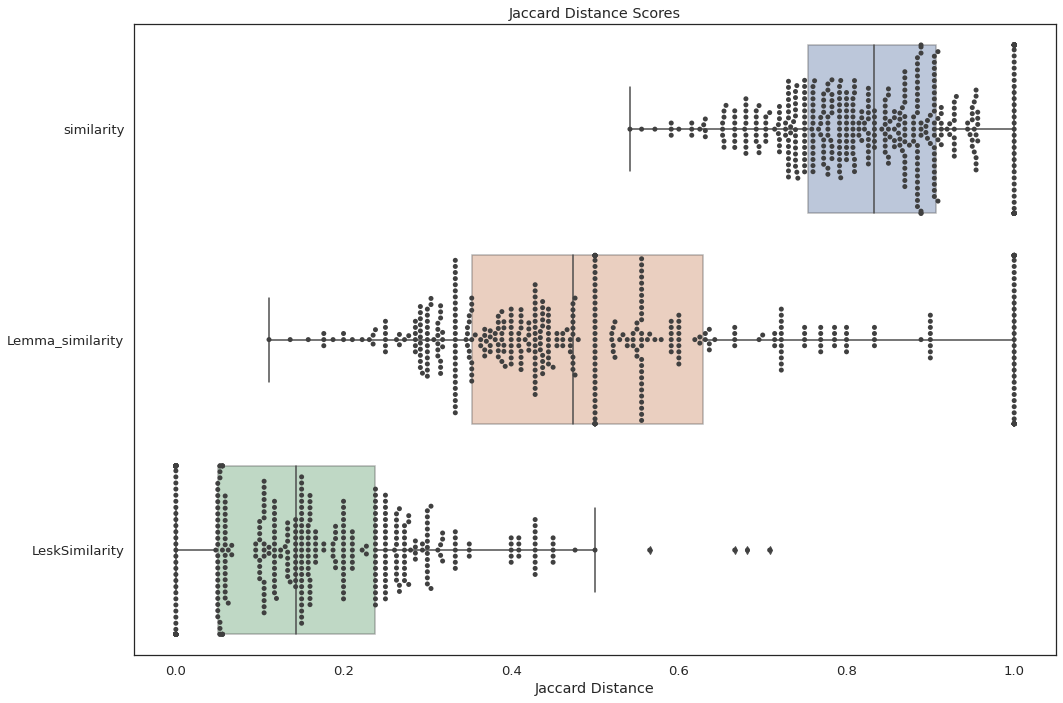

In [256]:
include_cols = ['similarity','Lemma_similarity','LeskSimilarity']
df_jaccardSimilarity = df[include_cols].copy()

FIG_SIZE = (15,10)
plt.figure(figsize=FIG_SIZE)
ax = sns.boxplot(data=df_jaccardSimilarity, orient="h",boxprops=dict(alpha=0.4))
ax = sns.swarmplot(data=df_jaccardSimilarity,orient="h",s=5,color="0.25")
ax.set_title('Jaccard Distance Scores')
ax.set_xlabel('Jaccard Distance')
plt.tight_layout()

# Conclusions
- One of the most notable aspects of this laboratory was the value obtained for the Pearson correlation from the Synsets-based Jaccard similarity, which was lower than the other values ​​obtained in previous laboratories. The reason for this result was probably due to disambiguation errors caused by identical or equivalent lemmas being mapped as different synsets, resulting in a decrease in the similarity measure.